# Developing the Xenium Cell-Level Reader

This notebook is used to **develop, debug, and validate** the Xenium cell-level data reading pipeline used in the production `read_xenium_cell` script.

The workflow focuses on:
- Loading Xenium spatial data and associated H&E images using **HEST**.
- Integrating externally generated **single-cell annotations** (`.h5ad`).
- Aligning cell coordinates to H&E pixel space.
- Pooling cells to pseudospots.
- Applying configurable **spatial exclusion rules** (e.g. strips, corners) defined in metadata.
- Verifying coordinate systems, exclusion behavior, and output integrity before batch execution on SLURM.

This notebook is intentionally **interactive and verbose**, allowing step-by-step inspection of:
- coordinate ranges (fractional vs pixel),
- rule parsing from Excel metadata,
- effects of each exclusion rule,
- and intermediate outputs (masks, overlays, counts).

Once validated here, the logic is migrated into standalone production scripts.  
Specifically, this notebook is used to develop **`11_read_xenium_5k_cell.py`**, which can be:
- executed directly via **`11_read_xenium_5k_cell_cpu.py`** with a specified `SampleID`, or  
- run at scale as a SLURM job array using **`11_read_xenium_5k_cell_cpu_parallel.py`** with a text file listing sample IDs.

In [15]:
from hest import iter_hest, XeniumReader
from hest.HESTData import *
from gutdecoder.reader import h5ad_reader
from gutdecoder.reader.h5ad_reader import *
from gutdecoder.vis import plot
import dask
dask.config.set({'dataframe.query-planning': False})
from pathlib import Path
import hest
print(hest.__version__)
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from hest.utils import *

# check gpu cucim
import cucim
print(cucim.__version__)
from cucim import CuImage

0.0.1


ModuleNotFoundError: No module named 'cucim'

# XeniumPR1S1ROI1 (re-processed)

In [31]:
out_dir = Path("/project/simmons_hts/kxu/hest/xenium_data/XeniumR2/slide1/ROI1")
align_csv = Path("/project/simmons_hts/kxu/xenium/he/480/RUN2/XeniumR2S1ROI1_alignment_files/matrix.csv")
st = read_HESTData(
    str(out_dir / 'aligned_adata.h5ad'), 
    str(out_dir / 'aligned_fullres_HE.tif'), 
    str(out_dir / 'metrics.json')
)
st

        'pixel_size' is 0.22050904501351665
        'wsi' is <width=26049, height=33542, backend=OpenSlideWSI>
        'shapes': []

In [32]:
adata_labelled = sc.read_h5ad("/project/simmons_hts/kxu/hest/xenium_labelled/fistula_480/h5ad/XeniumR2S1ROI1.h5ad")
adata_labelled

AnnData object with n_obs × n_vars = 108079 × 541
    obs: 'nCount_xenium', 'nFeature_xenium', 'cell', 'x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'CellAnnotation.Level1', 'CellAnnotation.Level2', 'CellAnnotation.Level3.Corrected', 'CellAnnotation.Level0'
    var: 'names'
    obsm: 'X_harmony_full'

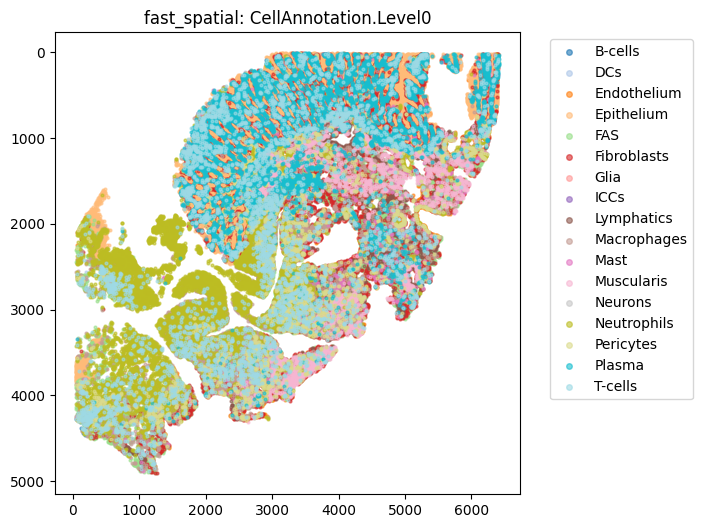

/home/k/kxu/.local/lib/python3.11/site-packages/gutdecoder/reader/h5ad_reader.py:34: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "spatial" in adata.obsm_keys():


aligned


In [ ]:
# --- labelled single-cell data ---
adata_labelled = sc.read_h5ad("/project/simmons_hts/kxu/hest/xenium_labelled/fistula_480/h5ad/XeniumR2S1ROI1.h5ad")
adata_labelled.obs[['cell_centroid_x']] = adata_labelled.obs[["x"]]
adata_labelled.obs[['cell_centroid_y']] = adata_labelled.obs[["y"]]
adata_labelled.obsm["spatial"] = adata_labelled.obs[["x","y"]].to_numpy()

fast_spatial(adata_labelled, 'CellAnnotation.Level0')
# fast_spatial(adata_labelled, 'CellAnnotation.Level1')
# fast_spatial(adata_labelled, 'CellAnnotation.Level2')
# fast_spatial(adata_labelled, 'CellAnnotation.Level3.Corrected')
# fast_spatial(adata_labelled, 'cluster')

# --- filter st.adata to WSI extent + drop Codeword features ---
update_st_with_filtered_and_labelled(st, adata_labelled, drop_codeword=True)

# --- align labelled cells to H&E pixel coords ---
px_um = st.meta["pixel_size"]
adata_labelled = align_labelled_to_he(adata_labelled, align_csv, pixel_size_um=px_um)
print('aligned')
# standardize column names / annotate
rename_map = {
        "cell_centroid_x": "x_centroid",
        "cell_centroid_y": "y_centroid",
        "cell": "cell_id",
        "CellAnnotation.Level0": "cell_type",
        "n_transcripts": "transcript_counts",
    }
adata_labelled = standardize_obs_columns(adata_labelled, rename_map = rename_map)
fast_spatial(adata_labelled, 'cell_type')

# --- quick sanity range of aligned coords ---
x_min, x_max, y_min, y_max = coord_range(adata_labelled.obsm["spatial"])
print(f"x:[{x_min:.1f}, {x_max:.1f}], y:[{y_min:.1f}, {y_max:.1f}]")

adata_labelled

In [36]:
adata_labelled

AnnData object with n_obs × n_vars = 108079 × 541
    obs: 'nCount_xenium', 'nFeature_xenium', 'cell_id', 'x', 'y', 'z', 'cluster', 'transcript_counts', 'density', 'elongation', 'area', 'CellAnnotation.Level1', 'CellAnnotation.Level2', 'CellAnnotation.Level3.Corrected', 'cell_type', 'x_centroid', 'y_centroid', 'he_x', 'he_y', 'segmentation_method'
    var: 'names'
    obsm: 'X_harmony_full', 'spatial'

In [37]:
adata_labelled.obs['cell_type']

CR6786cd647-10         Epithelium
CR6786cd647-100        Epithelium
CR6786cd647-1000      Macrophages
CR6786cd647-10000          Plasma
CR6786cd647-100002            FAS
                         ...     
CR6786cd647-99994     Neutrophils
CR6786cd647-99995     Macrophages
CR6786cd647-99996      Epithelium
CR6786cd647-99998     Macrophages
CR6786cd647-99999     Neutrophils
Name: cell_type, Length: 108079, dtype: category
Categories (17, object): ['B-cells', 'DCs', 'Endothelium', 'Epithelium', ..., 'Neutrophils', 'Pericytes', 'Plasma', 'T-cells']

In [38]:
# create cell type df
cell_df = adata_labelled.obs[['cell_type', 'he_x', 'he_y']].rename(columns={'cell_type': 'feature_name'})
cell_df

,feature_name,he_x,he_y
CR6786cd647-10,Epithelium,15256.441207,5993.657255
CR6786cd647-100,Epithelium,14511.991158,5517.584140
CR6786cd647-1000,Macrophages,11576.141187,4284.977298
CR6786cd647-10000,Plasma,17588.577696,13590.458373
CR6786cd647-100002,FAS,4829.312906,14767.483093
...,...,...,...
CR6786cd647-99994,Neutrophils,8752.006466,18640.970431
CR6786cd647-99995,Macrophages,10631.946772,20555.211479
CR6786cd647-99996,Epithelium,17875.626474,27767.123899
CR6786cd647-99998,Macrophages,8100.623249,18012.500384


In [39]:
from hest.readers import pool_transcripts_xenium
adata_cells_pooled = pool_transcripts_xenium(
                cell_df, 
                st.meta['pixel_size_um_estimated'], 
                key_x='he_x',
                key_y='he_y',
                spot_size_um=st.meta['spot_diameter']
            )

/package/python-cbrg/current/3.11.14/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [41]:
st.adata

AnnData object with n_obs × n_vars = 3162 × 500
    obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [42]:
adata_cells_pooled

AnnData object with n_obs × n_vars = 1842 × 17
    obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts'
    obsm: 'spatial'

In [43]:
# total counts per observation (cell / spot)
adata_cells_pooled.obs["total_counts"] = np.asarray(adata_cells_pooled.X.sum(axis=1)).ravel()

# log1p-transformed total counts
adata_cells_pooled.obs["log1p_total_counts"] = np.log1p(adata_cells_pooled.obs["total_counts"])

In [ ]:
# --- spot exclusions across full WSI ---

# get spot coords from st.adata
xy = st.adata.obsm["spatial"]
sx, sy = xy[:, 0], xy[:, 1]

# full WSI bounding box
xmin, xmax, ymin, ymax = 0, st.wsi.width, 0, st.wsi.height

# rules (edit as you like)
rules = [
    {"type": "strip", "side": "right", "size": 0.10, "units": "frac"},
    {'type':'corner', 'corner':'bottom-right', 'width':0.13, 'height':0.38, 'units':'frac'}
]

# apply rule-based exclusions directly
final_keep = apply_spot_exclusions(sx, sy, (xmin, xmax, ymin, ymax), rules)

print(f"Spots kept after rules: {final_keep.sum()} / {len(final_keep)}")

# visualize with scanpy
sc.pl.spatial(
    st.adata[final_keep],
    img_key="downscaled_fullres",
    color="total_counts",
    title="In-tissue spots (after rule exclusions)",
)

Spots kept after rules: 3162 / 3162


/tmp/ipykernel_1731616/1522164877.py:22: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


Spots kept after rules: 1842 / 1842


/tmp/ipykernel_1731616/987256811.py:22: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


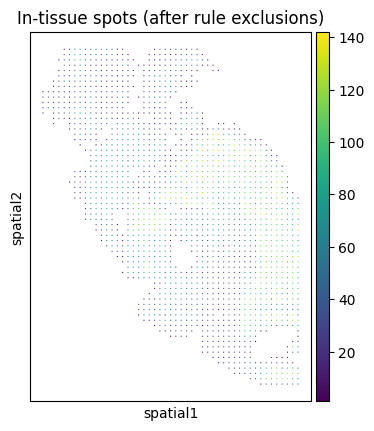

In [46]:
# --- spot exclusions across full WSI ---

# get spot coords from st.adata
xy = adata_cells_pooled.obsm["spatial"]
sx, sy = xy[:, 0], xy[:, 1]

# full WSI bounding box
xmin, xmax, ymin, ymax = 0, st.wsi.width, 0, st.wsi.height

# rules (edit as you like)
rules = [
    {"type": "strip", "side": "right", "size": 0.10, "units": "frac"},
    {'type':'corner', 'corner':'bottom-right', 'width':0.13, 'height':0.38, 'units':'frac'}
]

# apply rule-based exclusions directly
final_keep = apply_spot_exclusions(sx, sy, (xmin, xmax, ymin, ymax), rules)

print(f"Spots kept after rules: {final_keep.sum()} / {len(final_keep)}")

# visualize with scanpy
sc.pl.spatial(
    adata_cells_pooled[final_keep],
    img_key="downscaled_fullres",
    color="n_counts",
    title="In-tissue spots (after rule exclusions)",
    spot_size=100,
)

In [47]:
downscaled_fullres, downscale_factor = register_downscale_img(adata_cells_pooled, st.wsi, st.meta['pixel_size_um_estimated'])

In [48]:
# reattach (after alignment/renames)
st.adata = adata_cells_pooled[final_keep]

# --- meta refresh ---
stats = refresh_meta_counts(st)
print("Before/After:", stats)

out_dir = Path("/project/simmons_hts/kxu/hest/xenium_data/XeniumR2_cell_l0/slide1/ROI1")
overlay_path = save_all(st, out_dir, pyramidal=True)
print("Overlay saved:", overlay_path)

Before/After: {'old': {'num_cells': 901036, 'cells_under_tissue': 901036, 'transcripts_per_cell': 64, 'total_cell_area': None}, 'new': {'num_cells': 108079, 'cells_under_tissue': 108079, 'transcripts_per_cell': 233.09769705493204, 'total_cell_area': nan}}


/home/k/kxu/.local/lib/python3.11/site-packages/hest/HESTData.py:1390: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(adata, show=False, img_key="downscaled_fullres", color=[key], title=f"in_tissue spots", return_fig=True, **pl_kwargs)


saving to pyramidal tiff... can be slow


/home/k/kxu/.local/lib/python3.11/site-packages/gutdecoder/reader/h5ad_reader.py:324: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


# inspect saved h5ad -> add all cell types manually

Issue: different adata have different cells (n_vars varies)

```bash
!python /ceph/project/simmons_hts/kxu/hest/code/01_read_data/04_pad_cell_adata_xeniumpr1-3.py


execute /ceph/project/simmons_hts/kxu/hest/code/01_read_data/04_pad_cell_adata_xeniumpr1-3.py to produce padded xenium adata with all cell types as var names in the same order

#### inspect padded data

In [140]:
adata = sc.read_h5ad('/project/simmons_hts/kxu/hest/xenium_data/XeniumPR3_cell/slide1/ROI8/aligned_adata.h5ad')

In [141]:
adata

AnnData object with n_obs × n_vars = 1020 × 16
    obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [143]:
adata.var_names

Index(['B-cells', 'CD4+_Tcells', 'CD8+_Tcells', 'DCs', 'Endothelium',
       'Epithelium', 'Glia', 'Lymphatics', 'Macrophages', 'Mast', 'Muscularis',
       'Neutrophils', 'Pericytes', 'Plasma', 'S1/S2', 'S3'],
      dtype='object')

In [ ]:
sc.pl.spatial(
    adata,
    img_key="downscaled_fullres",
    color="n_counts",
    title="In-tissue spots (after rule exclusions)",
    spot_size=200,
)

In [144]:
adata = sc.read_h5ad('/project/simmons_hts/kxu/hest/xenium_data/XeniumPR3_cell/slide1/ROI5/aligned_adata.h5ad')
adata.var_names

Index(['B-cells', 'CD4+_Tcells', 'CD8+_Tcells', 'DCs', 'Endothelium',
       'Epithelium', 'Glia', 'Lymphatics', 'Macrophages', 'Mast', 'Muscularis',
       'Neutrophils', 'Pericytes', 'Plasma', 'S1/S2', 'S3'],
      dtype='object')

## development code

In [119]:
from pathlib import Path
import scanpy as sc

adata_dir = Path("/project/simmons_hts/kxu/hest/eval/data/XeniumPR1-3_cell/adata")

adatas = {
    p.stem: sc.read_h5ad(p)
    for p in sorted(adata_dir.glob("*.h5ad"))
}

print(f"Loaded {len(adatas)} AnnData objects")

Loaded 31 AnnData objects


In [120]:
adatas

{'XeniumPR1S1ROI1': AnnData object with n_obs × n_vars = 634 × 15
     obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'total_counts', 'log1p_total_counts'
     uns: 'spatial'
     obsm: 'spatial',
 'XeniumPR1S1ROI2': AnnData object with n_obs × n_vars = 451 × 14
     obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'total_counts', 'log1p_total_counts'
     uns: 'spatial'
     obsm: 'spatial',
 'XeniumPR1S1ROI3': AnnData object with n_obs × n_vars = 959 × 12
     obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'total_counts', 'log1p_total_counts'
     uns: 'spatial'
     obsm: 'spatial',
 'XeniumPR1S1ROI4': AnnData object with n_obs × n_vars = 1073 × 12
     obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'total_counts', 'log1p_total_counts'
     uns: 'spatial'
     obsm: 'spatial',

In [121]:
var_union = sorted(
    set().union(*(ad.var_names for ad in adatas.values()))
)
var_union
print(f"Union size: {len(var_union)}")
var_union

Union size: 16


['B-cells',
 'CD4+_Tcells',
 'CD8+_Tcells',
 'DCs',
 'Endothelium',
 'Epithelium',
 'Glia',
 'Lymphatics',
 'Macrophages',
 'Mast',
 'Muscularis',
 'Neutrophils',
 'Pericytes',
 'Plasma',
 'S1/S2',
 'S3']

In [122]:
from copy import deepcopy
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.sparse as sp
import anndata as ad

def _hstack_preserve_sparse(X, zeros):
    # helpers to hstack preserving CSR/CSC
    if sp.issparse(X):
        # make sure result is CSR
        return sp.hstack([X, zeros], format="csr")
    else:
        return np.hstack([X, zeros])

def _make_zeros(n_rows, n_cols, like):
    if sp.issparse(like):
        return sp.csr_matrix((n_rows, n_cols), dtype=like.dtype)
    else:
        dtype = like.dtype if hasattr(like, "dtype") else float
        return np.zeros((n_rows, n_cols), dtype=dtype)

def pad_adata_to_var_union_preserve(adata, var_union):
    """
    Return a new AnnData with the same obs/obsm/uns/etc but with columns (var)
    equal to var_union. Missing vars become columns of zeros in X and in layers;
    var metadata rows are NaN (except we fill a 'gene'/'feature' column if present).
    This does NOT mutate the input adata.
    """

    # Normalize var_union
    if isinstance(var_union, (list, tuple, np.ndarray, pd.Index)):
        var_union = list(dict.fromkeys(map(str, var_union)))
    else:
        raise ValueError("var_union must be list-like")

    existing_vars = list(map(str, adata.var_names))
    missing = [v for v in var_union if v not in existing_vars]
    n_missing = len(missing)
    n_obs = adata.n_obs

    # Build X_new
    X = adata.X
    if n_missing == 0:
        # Just reindex var metadata (ensure order) and return a copy with same data
        new_var = adata.var.reindex(var_union)
        new_adata = ad.AnnData(
            X = X.copy() if (not sp.issparse(X)) else X.copy(),
            obs = adata.obs.copy(),
            var = new_var.copy(),
            obsm = deepcopy(adata.obsm),
            uns = deepcopy(adata.uns),
            obsp = deepcopy(getattr(adata, "obsp", {})),
            varm = deepcopy(getattr(adata, "varm", {})),
            layers = deepcopy(getattr(adata, "layers", {})),
        )
        # keep raw if present
        if adata.raw is not None:
            new_adata.raw = deepcopy(adata.raw)
        return new_adata

    zeros = _make_zeros(n_obs, n_missing, X)
    X_new = _hstack_preserve_sparse(X, zeros)

    # Build new var DataFrame: existing followed by missing (so X_new matches order)
    if adata.var is None or adata.var.shape[0] == 0:
        var_existing_df = pd.DataFrame(index=existing_vars)
    else:
        var_existing_df = adata.var.copy()

    cols = var_existing_df.columns.tolist()
    if len(cols) == 0:
        var_missing_df = pd.DataFrame(index=missing)
    else:
        var_missing_df = pd.DataFrame(index=missing, columns=cols)
        # fill gene/feature column with var name if such column exists
        if "gene" in cols:
            var_missing_df["gene"] = missing
        elif "feature" in cols:
            var_missing_df["feature"] = missing

    var_concat = pd.concat([var_existing_df, var_missing_df], axis=0)
    var_concat.index = var_concat.index.map(str)

    # Layers: pad each layer that has shape (n_obs, n_vars)
    layers_new = {}
    for layer_name, layer_data in getattr(adata, "layers", {}).items():
        if layer_data is None:
            layers_new[layer_name] = None
            continue
        # ensure rows==n_obs
        if layer_data.shape[0] != n_obs:
            # unexpected shape; just copy as-is (can't safely pad)
            layers_new[layer_name] = deepcopy(layer_data)
            continue
        if layer_data.shape[1] != len(existing_vars):
            # unexpected shape; copy
            layers_new[layer_name] = deepcopy(layer_data)
            continue
        zeros_layer = _make_zeros(n_obs, n_missing, layer_data)
        layers_new[layer_name] = _hstack_preserve_sparse(layer_data, zeros_layer)

    # varm: typically variable annotations (var × k). We reindex rows to var_union.
    varm_new = {}
    for k, v in getattr(adata, "varm", {}).items():
        # v is array with first dim == n_vars usually
        if v.shape[0] != len(existing_vars):
            # can't safely pad, copy
            varm_new[k] = deepcopy(v)
            continue
        # make zero rows for missing
        extra_shape = (n_missing,) + v.shape[1:]
        zeros_v = np.zeros(extra_shape, dtype=v.dtype)
        varm_new[k] = np.vstack([v, zeros_v])

    # obsp, uns, obsm: copy as-is (they relate to obs/other structures, not var)
    obsp_copy = deepcopy(getattr(adata, "obsp", {}))
    obsm_copy = deepcopy(getattr(adata, "obsm", {}))
    uns_copy = deepcopy(getattr(adata, "uns", {}))

    # Build the new AnnData (existing vars first, then missing -> matches X_new)
    new_adata = ad.AnnData(
        X = X_new,
        obs = adata.obs.copy(),
        var = var_concat.copy(),
        obsm = obsm_copy,
        uns = uns_copy,
        obsp = obsp_copy,
        varm = varm_new,
        layers = layers_new
    )

    # Reindex columns to var_union order (already in that order because we concatenated existing then missing),
    # but ensure var_names exactly equals var_union
    new_adata.var_names = pd.Index(var_union)

    # Copy raw if present -- raw.n_var must match; raw is trickier: we can't pad raw automatically reliably.
    if getattr(adata, "raw", None) is not None:
        try:
            new_adata.raw = deepcopy(adata.raw)
        except Exception:
            # If raw cannot be copied/preserved (shape mismatch), drop it and warn the user.
            new_adata.raw = None
            print("Warning: couldn't preserve adata.raw for", adata)

    return new_adata

# Usage on your dict:
var_union = sorted(set().union(*(ad.var_names for ad in adatas.values())))
for k, a in list(adatas.items()):
    print(f"Padding {k}: {a.n_obs} obs, {a.n_vars} vars -> {len(var_union)} vars")
    adatas[k] = pad_adata_to_var_union_preserve(a, var_union)

# Quick sanity check:
import pandas as pd
assert all((ad.var_names == pd.Index(var_union)).all() for ad in adatas.values())
print("Done — all AnnData objects now have the same var_names and obsm/uns preserved for samples.")



Padding XeniumPR1S1ROI1: 634 obs, 15 vars -> 16 vars
Padding XeniumPR1S1ROI2: 451 obs, 14 vars -> 16 vars
Padding XeniumPR1S1ROI3: 959 obs, 12 vars -> 16 vars
Padding XeniumPR1S1ROI4: 1073 obs, 12 vars -> 16 vars
Padding XeniumPR1S1ROI5: 803 obs, 14 vars -> 16 vars
Padding XeniumPR1S1ROI6: 2373 obs, 15 vars -> 16 vars
Padding XeniumPR1S1ROI7: 2480 obs, 15 vars -> 16 vars
Padding XeniumPR1S1ROI8: 3474 obs, 15 vars -> 16 vars
Padding XeniumPR1S2ROI1: 2912 obs, 15 vars -> 16 vars
Padding XeniumPR1S2ROI2: 2421 obs, 16 vars -> 16 vars
Padding XeniumPR1S2ROI3: 1459 obs, 15 vars -> 16 vars
Padding XeniumPR1S2ROI4: 2499 obs, 16 vars -> 16 vars
Padding XeniumPR1S2ROI5: 901 obs, 15 vars -> 16 vars
Padding XeniumPR1S2ROI6: 1679 obs, 14 vars -> 16 vars
Padding XeniumPR1S2ROI7: 997 obs, 15 vars -> 16 vars
Padding XeniumPR2S1ROI1: 2847 obs, 14 vars -> 16 vars
Padding XeniumPR2S1ROI2: 2408 obs, 15 vars -> 16 vars
Padding XeniumPR2S1ROI3: 2061 obs, 13 vars -> 16 vars
Padding XeniumPR2S1ROI4: 1584 obs,

In [123]:
adatas

{'XeniumPR1S1ROI1': AnnData object with n_obs × n_vars = 634 × 16
     obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'total_counts', 'log1p_total_counts'
     uns: 'spatial'
     obsm: 'spatial',
 'XeniumPR1S1ROI2': AnnData object with n_obs × n_vars = 451 × 16
     obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'total_counts', 'log1p_total_counts'
     uns: 'spatial'
     obsm: 'spatial',
 'XeniumPR1S1ROI3': AnnData object with n_obs × n_vars = 959 × 16
     obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'total_counts', 'log1p_total_counts'
     uns: 'spatial'
     obsm: 'spatial',
 'XeniumPR1S1ROI4': AnnData object with n_obs × n_vars = 1073 × 16
     obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'total_counts', 'log1p_total_counts'
     uns: 'spatial'
     obsm: 'spatial',

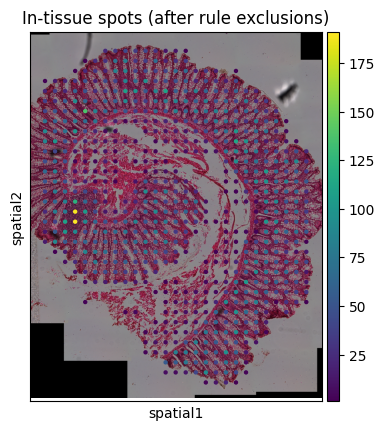

In [129]:
sc.pl.spatial(
    adatas['XeniumPR1S1ROI1'],
    img_key="downscaled_fullres",
    color="n_counts",
    title="In-tissue spots (after rule exclusions)",
    spot_size=100,
)

In [131]:
out_root = adata_dir  # reuse same root
adata_dir = Path("/project/simmons_hts/kxu/hest/eval/data/XeniumPR1-3_cell/adata")

for sample, adata in adatas.items():
    print(f"Processing {sample}: {adata.n_obs} obs, {adata.n_vars} vars")

    # Pad to union (returns a new AnnData)
    adata_padded = pad_adata_to_var_union_preserve(adata, var_union)

    # Save with original name
    out_path = out_root / f"{sample}.h5ad"
    adata_padded.write_h5ad(out_path)

    print(f"  → saved to {out_path}")

Processing XeniumPR1S1ROI1: 634 obs, 16 vars
  → saved to /project/simmons_hts/kxu/hest/eval/data/XeniumPR1-3_cell/adata/XeniumPR1S1ROI1.h5ad
Processing XeniumPR1S1ROI2: 451 obs, 16 vars
  → saved to /project/simmons_hts/kxu/hest/eval/data/XeniumPR1-3_cell/adata/XeniumPR1S1ROI2.h5ad
Processing XeniumPR1S1ROI3: 959 obs, 16 vars
  → saved to /project/simmons_hts/kxu/hest/eval/data/XeniumPR1-3_cell/adata/XeniumPR1S1ROI3.h5ad
Processing XeniumPR1S1ROI4: 1073 obs, 16 vars
  → saved to /project/simmons_hts/kxu/hest/eval/data/XeniumPR1-3_cell/adata/XeniumPR1S1ROI4.h5ad
Processing XeniumPR1S1ROI5: 803 obs, 16 vars
  → saved to /project/simmons_hts/kxu/hest/eval/data/XeniumPR1-3_cell/adata/XeniumPR1S1ROI5.h5ad
Processing XeniumPR1S1ROI6: 2373 obs, 16 vars
  → saved to /project/simmons_hts/kxu/hest/eval/data/XeniumPR1-3_cell/adata/XeniumPR1S1ROI6.h5ad
Processing XeniumPR1S1ROI7: 2480 obs, 16 vars
  → saved to /project/simmons_hts/kxu/hest/eval/data/XeniumPR1-3_cell/adata/XeniumPR1S1ROI7.h5ad
Pro